<a href="https://colab.research.google.com/github/tom5610/ai-ml-workshop/blob/main/notes/sequence_time_series_prediction_week03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [21]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start: end], series[start: end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(False)

def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1, np.cos(season_time * 6 * np.pi), 2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype = 'float32')
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 51)


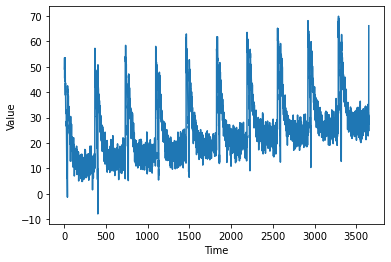

In [22]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time, series)

In [35]:


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # print(list(dataset.as_numpy_iterator())

    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    # index = 0
    # for window in dataset:
    #     list(window.as_numpy_iterator()
    #     index += 1
    #     if index > 3:
    #         break
             
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # print(list(dataset.as_numpy_iterator()))

    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # print(list(dataset.as_numpy_iterator()))

    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    # input_shape of lambda layer is the array with window_size
    # remember - RNN requires 3D input: samples, time_step & features;
    # and the input layer is 1D time step with window_size and each element is the feature. So, expand dims at the very end will wrap feature separately.
    # with that, the layer 0 output will be [None, window_size, 1] if input_shape = [window_size]
    # otherwise, it will be [None, None, 1] if input_shape = [None] (which accepts arbitrary length of window_size)
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ['mae'])
model.summary()
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 9s 28ms/step - loss: 20.3828 - mae: 20.8828
Epoch 2/100
94/94 [==

(1e-08, 0.0001, 0.0, 30.0)

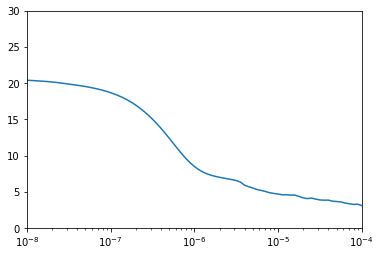

In [59]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9), metrics = ['mae'])
history = model.fit(dataset, epochs = 500, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
94/94 [==============================] - 41s 28ms/step - loss: 263.1985 - mae: 10.1378
Epoch 2/500
94/94 [==============================] - 3s 28ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/500
94/94 [==============================] - 3s 29ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/500
94/94 [==============================] - 3s 29ms/step - loss: 31.9160 - mae: 3.9759
Epoch 5/500
94/94 [==============================] - 3s 30ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/500
94/94 [==============================] - 3s 29ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/500
94/94 [==============================] - 3s 29ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/500
94/94 [==============================] - 3s 29ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/500
94/94 [==============================] - 3s 28ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/500
94/94 [==============================] - 3s 29ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/500
94/94 [================

In [47]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))


forecast = forecast[split_time - window_size:]

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

In [ ]:
print(forecast)

In [48]:

result = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.Tensor(
[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]], shape=(3, 2, 1), dtype=float32)


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()